In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
# combining the train and test dataset, without the 'SalePrice' and 'Id' columns now
# so as to not interfere when separating for X_train, X_test, and y

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

Looking at the distrbution of the SalePrice, and a ln(x+1) transformation on SalePrice.

- ln(x+1) is used just in case there are any discontinuities or any values at 0, it will not break the code.

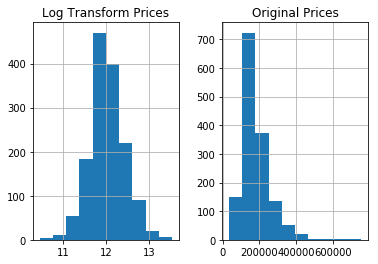

In [4]:
prices = pd.DataFrame({"Original Prices":train["SalePrice"],
                       "Log Transform Prices":np.log1p(train["SalePrice"])})

prices.hist()
plt.show()

In [5]:
print('The skewness value for regular SalePrice is: ' + str(skew(train['SalePrice'])))

The skewness value for regular SalePrice is: 1.880940746034036


In [6]:
# transforming the saleprice variable
train["SalePrice"] = np.log1p(train["SalePrice"])

# the new skewness value
print('The skewness value for the transformed SalePrice is: ' + str(skew(train['SalePrice'])))

The skewness value for the transformed SalePrice is: 0.12122191311528359


In [7]:
num_feats = all_data.dtypes[all_data.dtypes != 'object'].index
all_data[num_feats].isna().sum().sort_values(ascending=False).head(15)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
GarageCars        1
OverallCond       0
YearBuilt         0
YearRemodAdd      0
OverallQual       0
dtype: int64

Since it doesn't make sense to impute the `LotFrontage` or `GarageYrBlt` with a value of 0, we can either impute it with the mean or median of that column. Or use KNN (probably the best solution). 

Doing the safe route for now, by imputing the missing values with the median of the column.

In [8]:
all_data.LotFrontage = all_data.LotFrontage.fillna(all_data.LotFrontage.dropna().median())
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(all_data.GarageYrBlt.dropna().median())

Filling in the rest of the missing variables (mostly categorical at this point) with 0.

In [9]:
all_data = all_data.fillna(0)

Applying the log transform to all the features that have a skewness value above 0.75:

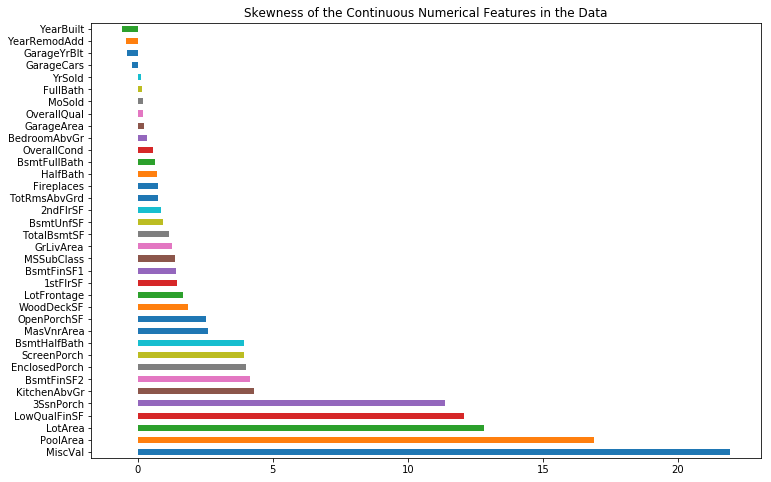

In [10]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)
skewed_feat_vals = all_data[num_feats].apply(lambda x: skew(x))
skewed_feat_vals = skewed_feat_vals.sort_values(ascending=False)

skewed_feat_vals.plot(kind = "barh")
plt.title("Skewness of the Continuous Numerical Features in the Data")
plt.show()

Log transforming any features that have a skewness of above 0.75:

In [11]:
skewed_feats = skewed_feat_vals[skewed_feat_vals > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

Transforming any categorical columns with strings into dummy columns (so it is either 0 or 1 depending on what category the observation falls into). 

In [12]:
all_data = pd.get_dummies(all_data, drop_first=True)
print('Dimensions of the final dataset: ' + str(all_data.shape))

Dimensions of the final dataset: (2919, 268)


Setting the `X_train`, `X_test`, and `y` variables for use with the Lasso Regularization model in sklearn. 

In [13]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [14]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

Defining a RMSE function to calculate the residual mean squared error to evaluate the model. To calcuate error, using `scoring = 'neg_mean_squared_error"` and setting the whole value negative to cancel out prior to taking the square root, as `scoring = 'mean_squared_error'` is deprecated in sklearn.

In [15]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = 5))
    return(rmse)

In [16]:
alpha_vals = np.logspace(-4, 4, 1000)

model_lasso_5CV = LassoCV(alphas = alpha_vals, normalize=True, cv=5).fit(X_train, y) 
print("Best alpha value: " + str(model_lasso_5CV.alpha_))
print("Corresponding R^2 score: " + str(model_lasso_5CV.score(X_train, y)))

Best alpha value: 0.00011805165285688056
Corresponding R^2 score: 0.924591525106737


In [17]:
print("Model using 5-fold CV for training:")
print("With 5-fold CV, the RMSE values are: " + str(rmse_cv(model_lasso_5CV, X_train, y)))
print("Average RMSE: " + str(rmse_cv(model_lasso_5CV, X_train, y).mean()))

Model using 5-fold CV for training:
With 5-fold CV, the RMSE values are: [0.10274701 0.1327937  0.13595896 0.11224453 0.14571762]
Average RMSE: 0.12589236250304145


Looking through the coefficients that were kept/eliminated and which ones were deemed important:

## Let's plot the lasso 

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [19]:
lasso = linear_model.Lasso(alpha=1)
alphas_lasso = np.logspace(-4, 0, 100)
coef_lasso = []
for i in alphas_lasso:
    lasso.set_params(alpha=i).fit(X_train,y)
    coef_lasso.append(lasso.coef_)



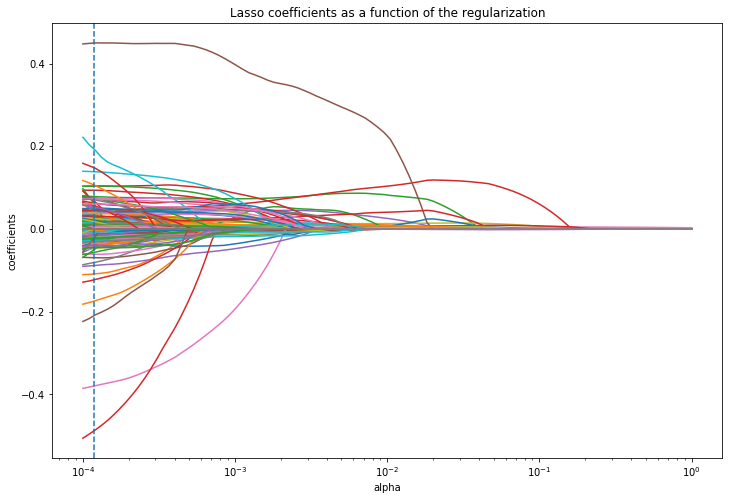

In [33]:
plt.figure(figsize=(20,20))
columns = X_train.columns
df_coef = pd.DataFrame(coef_lasso, index=alphas_lasso, columns=columns)
title = 'Lasso coefficients as a function of the regularization'
df_coef.plot(logx=True, title=title, legend=False)
plt.xlabel('alpha')
plt.ylabel('coefficients')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.axvline(x=model_lasso_5CV.alpha_,ls="dashed")
plt.savefig('./lasso.png', bbox_inches='tight', dpi = 300)

In [21]:
beta_vals = pd.Series(model_lasso_5CV.coef_, index = X_train.columns)

print("Variables kept: " + str(sum(beta_vals != 0)))
print("Variables eliminated: " + str(sum(beta_vals == 0)))

Variables kept: 92
Variables eliminated: 176


In [22]:
#print(beta_vals.sort_values().head(10))
#print(beta_vals.sort_values().tail(10))
important_feat = pd.concat([beta_vals.sort_values().head(10), beta_vals.sort_values().tail(10)])

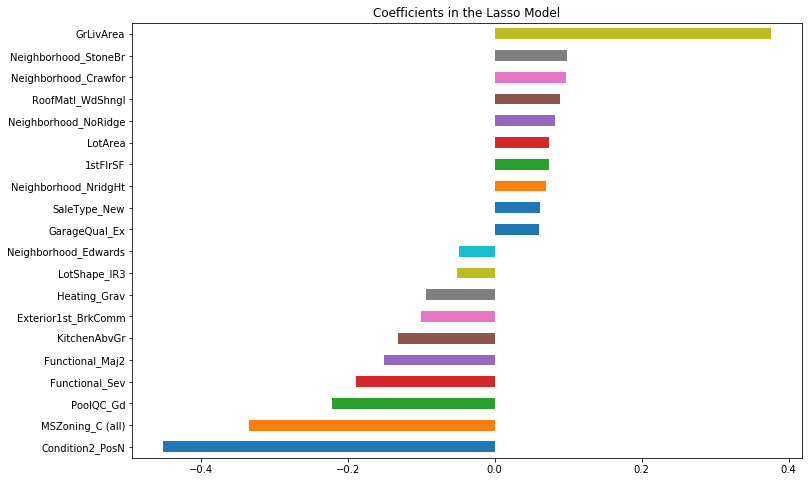

In [23]:
important_feat.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

## Plotting predictions vs actual

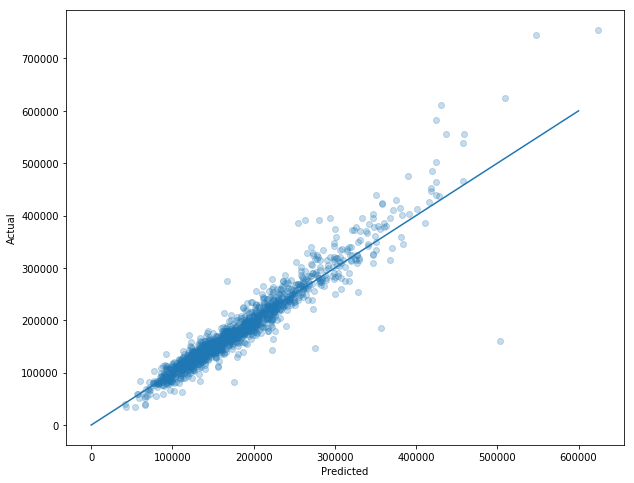

In [24]:
## Plotting the actual vs expected house price (along with the line x=y for reference)
training_set_predictions = np.expm1(model_lasso_5CV.predict(X_train))
actual_training_sales = np.expm1(y)
plt.figure(figsize=(10,8))
plt.scatter(training_set_predictions, actual_training_sales, alpha=.25)
plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))
plt.xlabel("Predicted")
plt.ylabel("Actual");


## Residuals plot

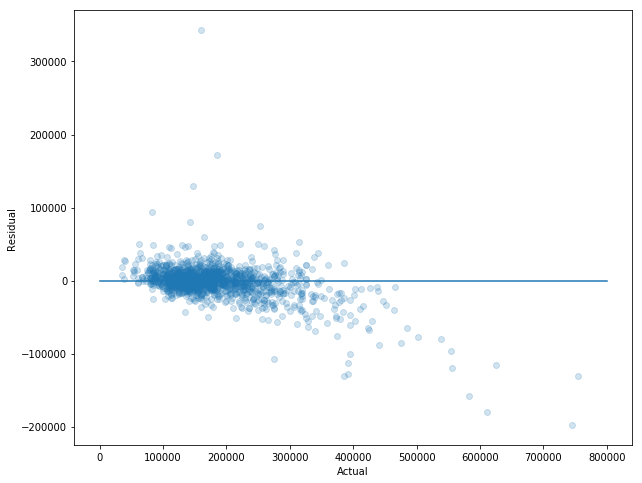

In [25]:
## Plotting the actual vs expected house price (along with the line x=y for reference)
training_set_predictions = np.expm1(model_lasso_5CV.predict(X_train))
actual_training_sales = np.expm1(y)
plt.figure(figsize=(10,8))
plt.scatter(actual_training_sales, training_set_predictions - actual_training_sales, alpha=.2)
plt.plot(np.linspace(0,800000,1000), np.linspace(0,0,1000))
plt.xlabel("Actual")
plt.ylabel("Residual");

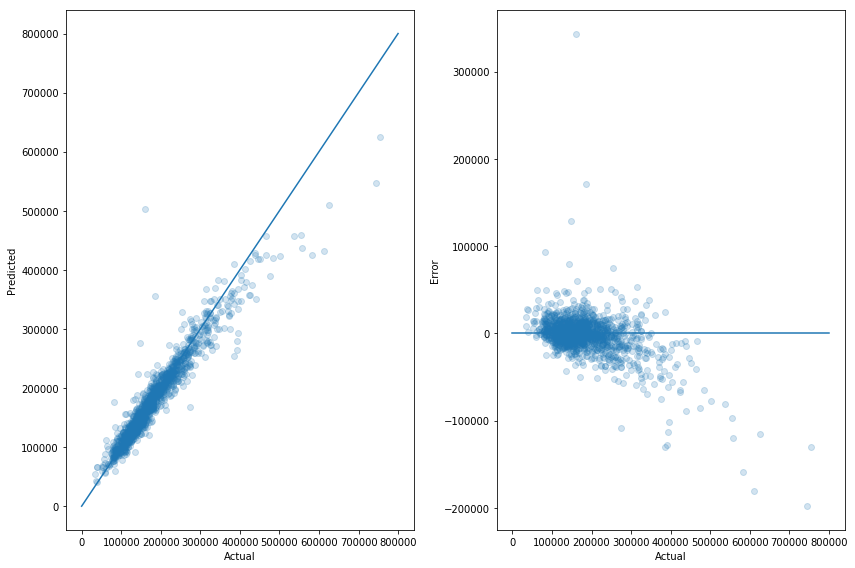

In [26]:
plt.subplot(1, 2, 1)

## Plotting the actual vs expected house price (along with the line x=y for reference)
training_set_predictions = np.expm1(model_lasso_5CV.predict(X_train))
actual_training_sales = np.expm1(y)
#plt.figure(figsize=(10,8))
plt.scatter(actual_training_sales, training_set_predictions, alpha=.2)
plt.plot(np.linspace(0,800000,1000), np.linspace(0,800000,1000))
plt.xlabel("Actual")
plt.ylabel("Predicted");


plt.subplot(1, 2, 2)

## Plotting the actual vs expected house price (along with the line x=y for reference)
training_set_predictions = np.expm1(model_lasso_5CV.predict(X_train))
actual_training_sales = np.expm1(y)
#plt.figure(figsize=(10,8))
plt.scatter(actual_training_sales, training_set_predictions - actual_training_sales, alpha=.2)
plt.plot(np.linspace(0,800000,1000), np.linspace(0,0,1000))
plt.xlabel("Actual")
plt.ylabel("Error");

plt.tight_layout()
plt.show()

# This creates a prediction file to submit to Kaggle

### It's commented out so you can just hit run all on the Kernel and not create a csv file...

In [27]:
'''
pred = np.expm1(model_lasso_5CV.predict(X_test))

submission = pd.DataFrame({'Id': test.Id, 'SalePrice': pred})
submission.to_csv('attempt_lasso_5cv_jakeigorhuang.csv', index=False)
'''

"\npred = np.expm1(model_lasso_5CV.predict(X_test))\n\nsubmission = pd.DataFrame({'Id': test.Id, 'SalePrice': pred})\nsubmission.to_csv('attempt_lasso_5cv_jakeigorhuang.csv', index=False)\n"